In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
df=pd.read_csv("/kaggle/input/diabets/machine_learning/datasets/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
y=df["Outcome"]
X=df.drop("Outcome",axis=1)

# Random Forests

In [4]:
rf_model = RandomForestClassifier(random_state=17)
rf_model.get_params()

cv_results = cross_validate(rf_model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()


rf_params = {"max_depth": [5, 8, None],
             "max_features": [3, 5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 15, 20],
             "n_estimators": [100, 200, 500]}


rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

rf_best_grid.best_params_

rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(rf_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()

Fitting 5 folds for each of 180 candidates, totalling 900 fits


0.8271054131054132

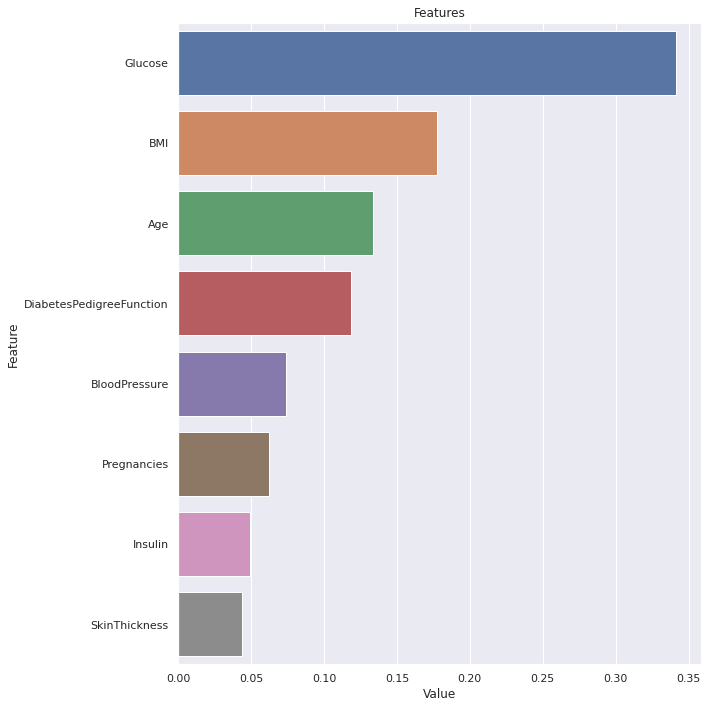

In [5]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_final, X)

In [6]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

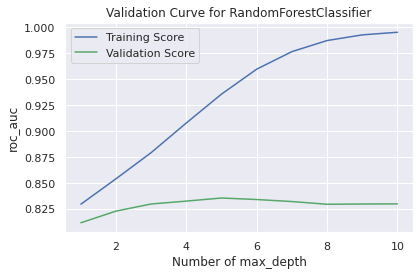

In [7]:
val_curve_params(rf_final, X, y, "max_depth", range(1, 11), scoring="roc_auc")

# GBM

In [8]:
gbm_model = GradientBoostingClassifier(random_state=17)

gbm_model.get_params()

cv_results = cross_validate(gbm_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()
# 0.7591715474068416
cv_results['test_f1'].mean()
# 0.634
cv_results['test_roc_auc'].mean()
# 0.82548
gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8, 10],
              "n_estimators": [100, 500, 1000],
              "subsample": [1, 0.5, 0.7]}


In [9]:
gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

gbm_best_grid.best_params_

gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=17, ).fit(X, y)


cv_results = cross_validate(gbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()

Fitting 5 folds for each of 54 candidates, totalling 270 fits


0.8241788958770091

# XGBoost

In [10]:
xgboost_model = XGBClassifier(random_state=17, use_label_encoder=False)
xgboost_model.get_params()
cv_results = cross_validate(xgboost_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()
# 0.75265
cv_results['test_f1'].mean()
# 0.631
cv_results['test_roc_auc'].mean()
# 0.7987

0.7987134870719776

In [11]:
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 500, 1000],
                  "colsample_bytree": [0.7, 1]}

xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(xgboost_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()

Fitting 5 folds for each of 24 candidates, totalling 120 fits


0.8193780573025856

# LightGBM

In [12]:
lgbm_model = LGBMClassifier(random_state=17)
lgbm_model.get_params()

cv_results = cross_validate(lgbm_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()

0.7990293501048218

In [13]:
lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [100, 300, 500, 1000],
               "colsample_bytree": [0.5, 0.7, 1]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()


Fitting 5 folds for each of 24 candidates, totalling 120 fits


0.8147491264849755

### Hiperparametre yeni değerlerle

In [14]:
lgbm_params = {"learning_rate": [0.01, 0.02, 0.05, 0.1],
               "n_estimators": [200, 300, 350, 400],
               "colsample_bytree": [0.9, 0.8, 1]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()

Fitting 5 folds for each of 48 candidates, totalling 240 fits


0.8227931516422082

### Hiperparametre optimizasyonu sadece n_estimators için.

In [15]:
lgbm_model = LGBMClassifier(random_state=17, colsample_bytree=0.9, learning_rate=0.01)

lgbm_params = {"n_estimators": [200, 400, 1000, 5000, 8000, 9000, 10000]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()


Fitting 5 folds for each of 7 candidates, totalling 35 fits


0.8227931516422082

# CatBoost

In [16]:
cat_but_num=[col for col in df.columns if (df[col].dtypes in ["float","int"])  and (df[col].nunique()<10) ]
num=[col for col in df.columns if (df[col].dtypes  in ["float","int"])]
cat=[col for col in df.columns if df[col].dtypes in ["Category","boolean"]] 

In [17]:
catboost_model = CatBoostClassifier(random_state=17, verbose=False)

cv_results = cross_validate(catboost_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()


0.8378923829489867

In [18]:
catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}


catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=17).fit(X, y)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [19]:
cv_results = cross_validate(catboost_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()

0.842001397624039

# Feature Importance

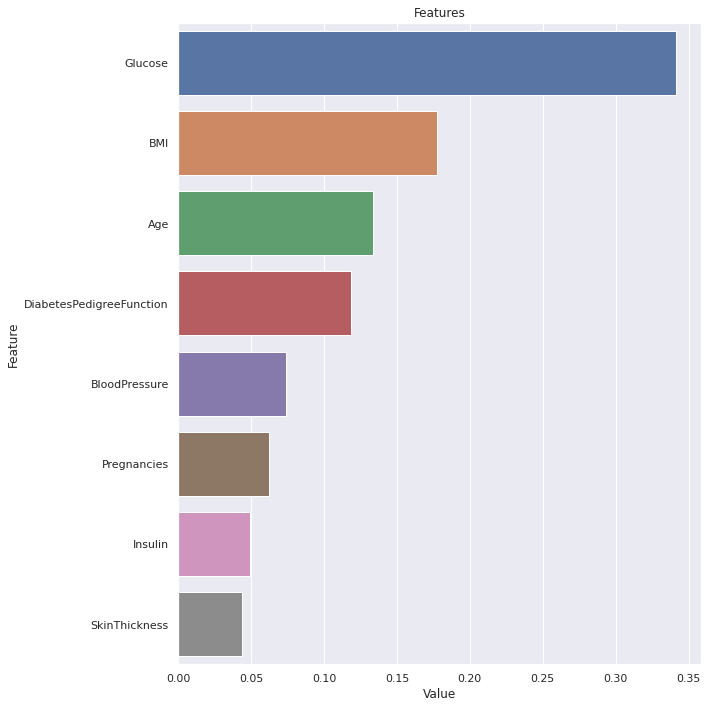

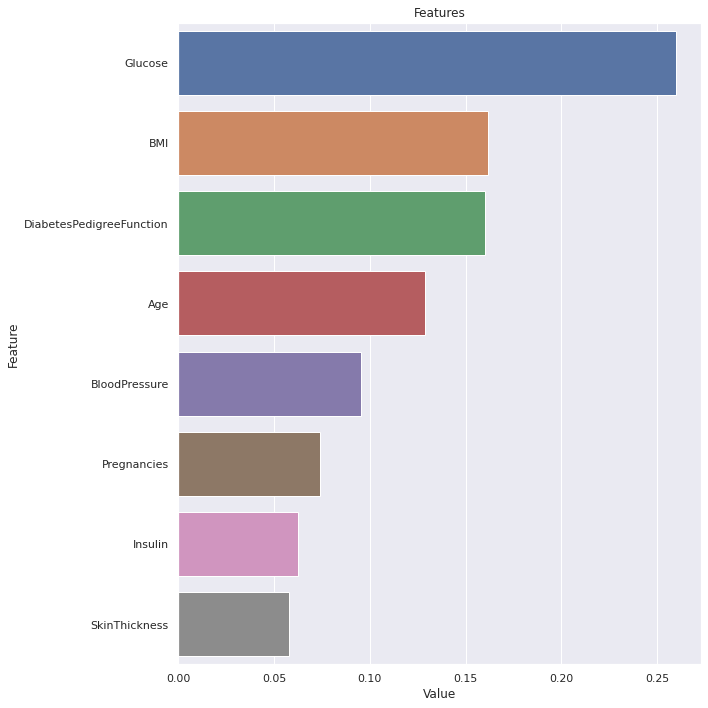

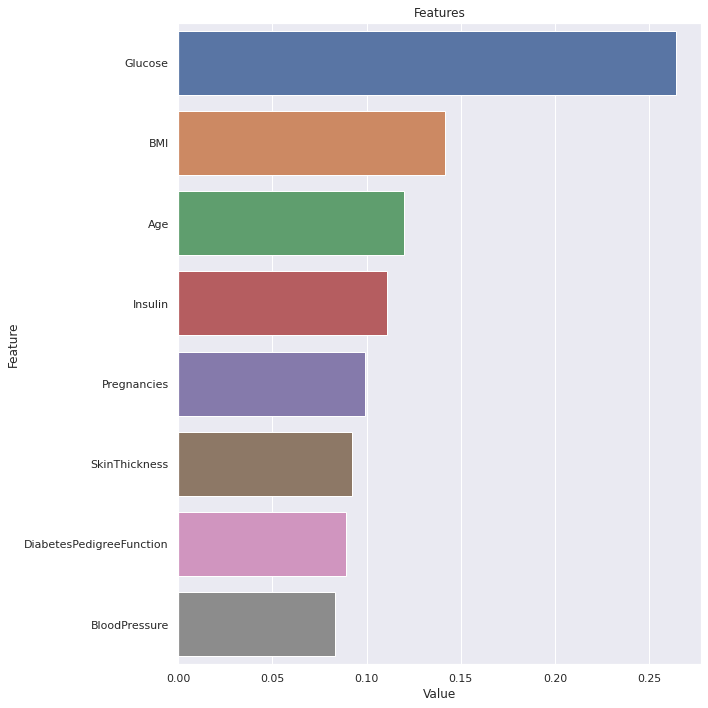

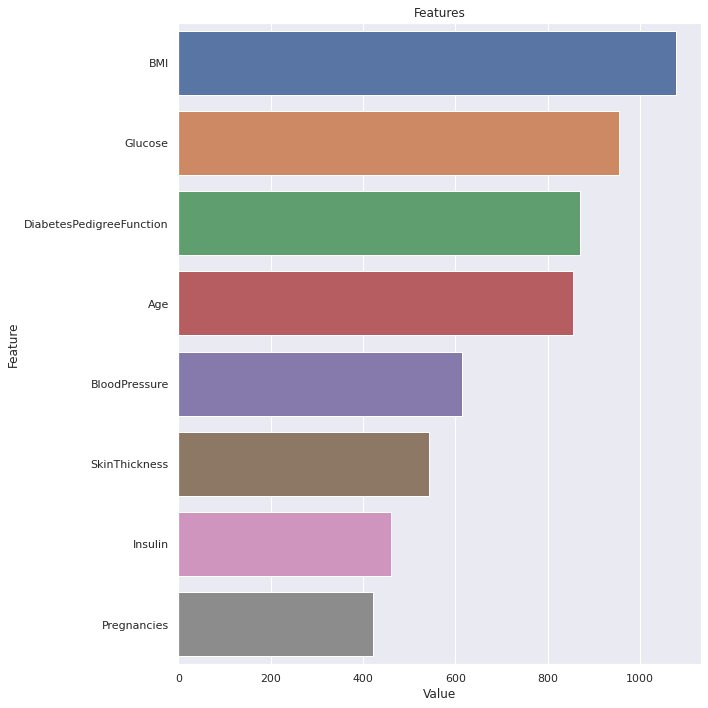

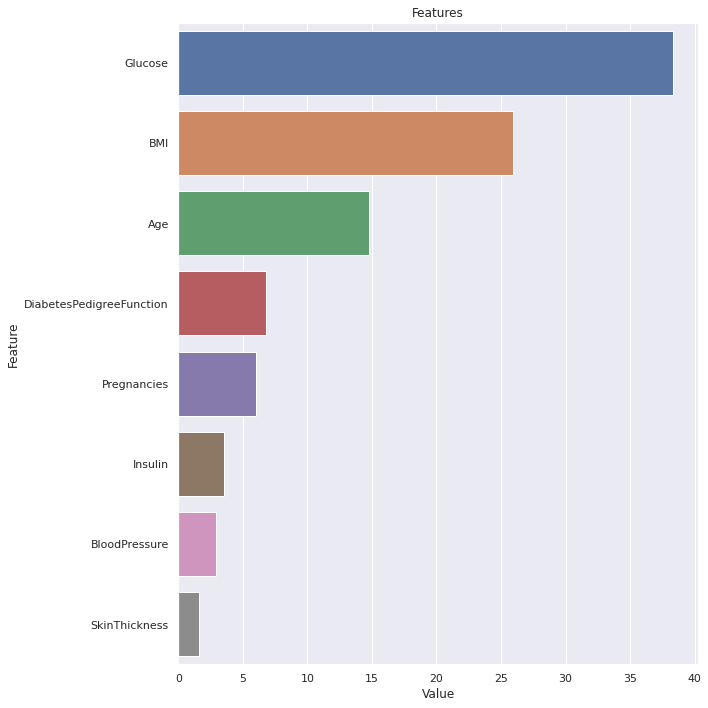

In [20]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_final, X)
plot_importance(gbm_final, X)
plot_importance(xgboost_final, X)
plot_importance(lgbm_final, X)
plot_importance(catboost_final, X)
